# How to EDinPy

Greetings! In this notebook you'll find some examples of how to use EDinPy to solve many-body problems. We'll start by getting familiar with some of the modules and classes.

## The `boson` and `fermion` submodules

EDinPy consists of 2 main classes: `boson` and `fermion`. For the time being, you'll only be able to program a purely bosonic or purely fermionic model. Both of these modules consist of the same classes and functions with the same arguments, except the arguments have to be structured differently in each case.

### Importing `boson` and `fermion`

The prefered way to import these submodules is as follows:


In [1]:
# for a fermionic system
from edinpy import fermion as edf
# and for a bosonic system
from edinpy import boson as edb

## Class types and functions

Now that you've succesfully imported the boson and fermion, let's look at some of the class types you'll need to get familiar with before proceeding further. For the moment, I'll be using the `fermion` submodule but everything I say will apply to `boson` unless otherwise stated.

### The `.DoF` class

The first step in creating a physical model is to define the degrees of freedom or "DoF"s. This is done with the `DoF` class, which works identically for both  `boson` and `fermion`. You can use `?` to see the docstring.

In [2]:
edf.DoF?

Init signature: edf.DoF(N_eigenvalues, name=None)
Docstring:     
Create a degree of freedom.
    
Parameters
----------
N_eigenvalues : int
    Number of eigenvalues of the associated observable, e.g. electron
    spin has 2 eigenvalues, a chain of 5 atoms has 5 position eigenvalues.
name : string
    Name of the observable.
File:           c:\users\alexs\miniconda3\lib\site-packages\edinpy\fermion\fermion.py
Type:           type
Subclasses:     

So, in order to create a DoF, you'll need to specify the number of eigenvalues the corresponding observable has. For instance, if we consider an chain of atoms of size $L$, the position operator $\hat{x}$ will have $L$ eigenvalues. The way to construct this DoF is as follows:

In [3]:
L = 4
x = edf.DoF(L, 'x') # the name parameter is optional, but its useful for error handling.

### The `.clear()` function

Before proceeding further it is important to know how DoFs are handled. Every time you call `.DoF` that DoF is stored in a `global list` that must be cleared if you wish to modify the DoFs of the model. If you're working in a notebook, its also necessary to call `.clear()` before calling `.DoF` if you want to rerun a cell. 

Say you want to modify change the number of sites in your chain from the previous $L = 4$ to $L=5$, as well as add an electron spin DoF. Your code should look something like this:

In [4]:
edf.clear()

x = edf.DoF(5, 'x')
spin = edf.DoF(2, 's')

### The `.model` class

Now that we've defined all our DoFs, we need to create and populate our model with particles. This is done with the `.model` class. Let's take a look at the docstring:

In [5]:
edf.model?

Init signature: edf.model(Nf, auto=True)
Docstring:     
Construct a model with the stored degrees of freedom.

Parameters
----------
Nf : int
    Number of fermions.
auto : bool
    If auto is True then the Fock space is calculated automatically, otherwise
    the user must use the build() method to calculate it manually.
File:           c:\users\alexs\miniconda3\lib\site-packages\edinpy\fermion\fermion.py
Type:           type
Subclasses:     

All we need to do is provide the number of fermions (or bosons) $N_{f}$ ($N_{b}$). The keyword argument `auto` tells `.model` whether to construct the relevant Fock space automatically or not. The `fockspace` attribute is an instance of the class `.fermionspace` for fermions and `.bosonspace` for bosons where the occupation number basis vectors are calculated and stored.

Let's generate our model and populate it with one particle, like so:

In [6]:
# Your code will look something like this
Nf = 1
mf = edf.model(Nf)

# Heres some of the attributes stored in the model 'mf'

print('DoFs of the model:',[dof.name for dof in mf.dofs])

prod = ''
for i in range(len(mf.dofs)-1):
    prod += f'{mf.dofs[i].N}*' 
prod += f'{mf.dofs[-1].N}'
print(f'Number of effective sites = {prod} = {mf.Neff}')

DoFs of the model: ['x', 's']
Number of effective sites = 5*2 = 10


#### What are "effective sites"?

You may have noticed an attribute called `Neff`, or the number of "effective sites". The way EDinPy handles multiple DoFs is by mapping an $N\text{D}$ problem onto a $1\text{D}$ problem. In our example, there are 5 atomic sites, however each site can hold $2$ fermions: $1$ spin-up and $1$ spin-down. Including a spin DoF effectively makes $2$ copies of the chain of length $5$ for spin-up and spin-down fermions, respectively. Therefore, the $1\text{D}$ equivalent problem would have $10$ sites. As another example, a $5\times5$ lattice with spin would be mapped to a $1\text{D}$ problem with $5\times5\times2 = 50$ sites.

When done by hand, the $N\text{D}$ $\rightarrow 1\text{D}$ mapping is increasingly tedious and time-consuming as $N$ grows. The beauty of EDinPy is that the mapping is done automatically, such that the index notation of the $N\text{D}$ problem is conserved but the calculation are done in the $1\text{D}$ problem to improve performance and efficiency.

### The `.fockstate` class

The basis vectors stored in the relevant fockspace class are a special object called `.fockstate`. This object type is a computational representation of a Fock state, which stores the probability amplitude (attribute `amp`) and a numerical representation of the occupation state vector (attribute `state`). The way the occupation vector is stored depends on whether your system is bosonic or fermionic.

In [7]:
edf.fockstate?

Init signature: edf.fockstate(state, amp=1, index=None)
Docstring:     
Create a fermionic Fock state.

Parameters
----------
state : int
    Occupation numbers of the effective sites represented as an integer.
amp : scalar
    Probability amplitude of the state. Default value is 1.
index : int
    Index of the state. Used when constructing a Fock space. Default is None.
File:           c:\users\alexs\miniconda3\lib\site-packages\edinpy\fermion\fermion.py
Type:           type
Subclasses:     vacuum

In [8]:
edb.fockstate?

Init signature: edb.fockstate(state, amp=1, index=None)
Docstring:     
Create a bosonic Fock state.

Parameters
----------
state : np.array
    Occupation numbers of the effective sites represented as a numpy array.
amp : scalar
    Probability amplitude of the state. Default value is 1.
index : int
    Index of the state. Used when constructing a Fock space. Default is None.
File:           c:\users\alexs\miniconda3\lib\site-packages\edinpy\boson\boson.py
Type:           type
Subclasses:     vacuum

#### Interpreting `.fockstate`

For fermionic Fock states, the `state` attribute is an instance of `int` which is the integer corresponding the occupation vector written in binary. For example, the state $|1,0\rangle$ is mapped to the binary number $01$ which is $1$ in base $10$. Meanwhile, the state $|0,1\rangle \rightarrow 10 ~\text{in binary} = 2 ~\text{ in base} ~10$.

For bosonic Fock states, `state` is an instance of `np.ndarray`, a numpy array. In this case, the occupation vector is mapped $1:1$ with the array, such that the $i$-th index of the array gives the occupation of the $i$-th effective site, i.e. `state[i]` $= n_i$. Unlike `fermion.fockstate`, `boson.fockstate` has a property called `tag`. This `tag` is a real number that uniquely identifies the occupation vector and is used to quickly compare two `boson.fockstate` when, say, projecting one state onto another.

Let's create a few fermionic Fock states.

In [9]:
state0 = 1
state1 = 2
state2 = 2; amp2 = 2j

fs0 = edf.fockstate(state0)
fs1 = edf.fockstate(state1)
fs1p = edf.fockstate(state1, amp = amp2)

# You can print the fock states see a human-readable string representation of the fock state
print('fs0 = ', fs0)
print('fs1 = ', fs1)
print('fs1p = ', fs1p)

print('Notice that the length of the occupation vector is 10, since the stored Neff variable = 10')

fs0 =  (1+0j)|1000000000>
fs1 =  (1+0j)|0100000000>
fs1p =  2j|0100000000>
Notice that the length of the occupation vector is 10, since the stored Neff variable = 10


An important thing to know is how to read the occupation vector when your model has multiple DoFs. The way effective site index $i$ is calculated, for a given set of DoFs {$d_0$, $d_1$,...} of dimension $D$, is as follows:
$$ i = i_{d_0} + \sum_{j=1}^{D-1} i_{d_j} \prod_{i=0}^{j-1} N_{d_i} = i_{d_0} + i_{d_1}N_{d_0} + i_{d_2}N_{d_0}N_{d_1} + ...$$
with $i_{d_j}$ the index of DoF $d_j$, where $N_{d_i}$ are the $N_{eigenvalues}$ of DoF $d_i$. In this example, the first DoF was $x$ and the second $s$ with $N_{eigenvalues} = 5, 2$, respectively, so:
$$ i = i_{x} + 5\cdot i_{s}$$
If we follow the convention $i_{s = \downarrow} = 0$ and $i_{s=\uparrow} = 1$, then the first (last) $5$ effective sites correspond to the positions $x$ of the spin-down (spin-up) fermions.

#### Arithmetic and logic operations between `.fockstate` 

The `.fockstate` object was programmed with the typical arithmetic and logic operators a user might need, such as addition `+`, subtraction `-`, and equality `==`. The inner product is represented by the `*` operator so that $\langle s_i| s_j \rangle = $ `s_i * s_j`. Below is a reference guide to how all these operations work and the objects they map to.

In [10]:

print('Unary operations')
py_pos = +fs0
py_neg = -fs0
print('+|fs0> =', py_pos, '; type ->', type(py_pos))
print('-|fs0> =', py_neg, '; type ->', type(py_neg))

print('\n Arithmetic operations')
addition = fs0 + fs1
subtraction = fs0 - fs1
print('|fs0> + |fs1> =', addition, '; type ->', type(addition))
print('|fs0> - |fs1> =', subtraction, '; type ->', type(subtraction))

print(' -> Inner product')
projection_00 = fs0*fs0
projection_11 = fs1*fs1
projection_22 = fs1p*fs1p
projection_01 = fs0*fs1
projection_10 = fs1*fs0
projection_12 = fs1*fs1p
projection_21 = fs1p*fs1
print('<fs0|fs0> =', projection_00, '; type ->', type(projection_00))
print('<fs1|fs1> =', projection_11, '; type ->', type(projection_11))
print('<fs1p|fs1p> =', projection_22, '; type ->', type(projection_22))
print('<fs0|fs1> =', projection_01, '; type ->', type(projection_01))
print('<fs1|fs0> =', projection_10, '; type ->', type(projection_10))
print('<fs1|fs1p> =', projection_12, '; type ->', type(projection_12))
print('<fs1p|fs1> =', projection_21, '; type ->', type(projection_21))

print('\n Equality (checks equality of occupation vector but NOT amplitude)')
equality_00 = fs0 == fs0
equality_10 = fs1 == fs0
equality_12 = fs1 == fs1p
print('|fs0> == |fs0>? ->', equality_00, '; type ->', type(equality_00))
print('|fs1> == |fs0>? ->', equality_10, '; type ->', type(equality_10))
print('|fs1> == |fs1p>? ->', equality_12, '; type ->', type(equality_12))

print('\n Identity (checks if is the same instance)')
py_is_11 = fs1 is fs1
py_is_12 = fs1 is fs1p
print('|fs1 is |fs1>? ->', py_is_11, '; type ->', type(py_is_11))
print('|fs1 is |fs1p>? ->', py_is_12, '; type ->', type(py_is_12))

Unary operations
+|fs0> = (1+0j)|1000000000> ; type -> <class 'edinpy.fermion.fermion.fockstate'>
-|fs0> = (-1-0j)|1000000000> ; type -> <class 'edinpy.fermion.fermion.fockstate'>

 Arithmetic operations
|fs0> + |fs1> = (1+0j)|1000000000> + (1+0j)|0100000000> ; type -> <class 'edinpy.fermion.fermion.statesum'>
|fs0> - |fs1> = (1+0j)|1000000000> + (-1-0j)|0100000000> ; type -> <class 'edinpy.fermion.fermion.statesum'>
 -> Inner product
<fs0|fs0> = (1+0j) ; type -> <class 'numpy.complex64'>
<fs1|fs1> = (1+0j) ; type -> <class 'numpy.complex64'>
<fs1p|fs1p> = (4+0j) ; type -> <class 'numpy.complex64'>
<fs0|fs1> = 0 ; type -> <class 'int'>
<fs1|fs0> = 0 ; type -> <class 'int'>
<fs1|fs1p> = 2j ; type -> <class 'numpy.complex64'>
<fs1p|fs1> = -2j ; type -> <class 'numpy.complex64'>

 Equality (checks equality of occupation vector but NOT amplitude)
|fs0> == |fs0>? -> True ; type -> <class 'bool'>
|fs1> == |fs0>? -> False ; type -> <class 'bool'>
|fs1> == |fs1p>? -> True ; type -> <class 'boo

#### The `.vacuum` subclass

A special subclass of `.fockstate` is the `.vacuum` object. This object represents the vacuum state of the system where no particles exist. This has the same attributes as a `.fockstate` but the algebra involving `.vacuum` states has been streamlined.

In [11]:
vac = edf.vacuum(amp = 1)
print('|vacuum> =', vac)

|vacuum> = (1+0j)|0>


### The `boson.bosonspace` and `fermion.fermionspace` classes

When you call the `.model` class, an instance of either `.bosonspace` or `.fermionspace` is created and stored in the attribute `model.fockspace`, whichever is appropriate. Although not very functional for the user at the moment, these classes calculate and store the Fock basis vectors. The user can access the Fock space and its attributes from the `.model` instance as follows:

In [12]:
ffs = mf.fockspace
print('Fock space type:', type(ffs))

print('\n You can print out all the basis vectors by calling the function show():')
ffs.show()

print('\n The basis vectors are stored in a list called basis')
fs0 = ffs.basis[0]
fs1 = ffs.basis[1]

print('ffs.basis[0] =', fs0)
print('ffs.basis[1] =', fs1)

Fock space type: <class 'edinpy.fermion.fermion.fermionspace'>

 You can print out all the basis vectors by calling the function show():
state 0: (1+0j)|1000000000>
state 1: (1+0j)|0100000000>
state 2: (1+0j)|0010000000>
state 3: (1+0j)|0001000000>
state 4: (1+0j)|0000100000>
state 5: (1+0j)|0000010000>
state 6: (1+0j)|0000001000>
state 7: (1+0j)|0000000100>
state 8: (1+0j)|0000000010>
state 9: (1+0j)|0000000001>

 The basis vectors are stored in a list called basis
ffs.basis[0] = (1+0j)|1000000000>
ffs.basis[1] = (1+0j)|0100000000>


### The `.operator` class

Once you build the model, you can construct the operators which act on the Fock space of your model. The `.operator` object is the computer representation of the annihilation operator. Let's see how to define our operators.

In [13]:
edf.operator?

Init signature: edf.operator(indices)
Docstring:     
Create an annihilation operator.

Parameters
----------
indices : iterable or int
    The indices which the operator acts on. If `indices` is an `int` then it is assumed 
    to refer to the effective site.
File:           c:\users\alexs\miniconda3\lib\site-packages\edinpy\fermion\fermion.py
Type:           type
Subclasses:     dagger, number

As you can see, the only thing we need to input as a parameter are the indices. The `indices` parameter can be any iterable (such as a `tuple`), where the entries preserve the order in which the DoFs were created. For example, our model has 2 DoFs, $x$ and $s$, in that order, so `indices` should be of the form $(i_{x}, i_{s})$. Below, the most convenient way to construct annihilation operators is shown:

In [14]:
# For convenience, we first assign the operator class to a variable
c = edf.operator

# To get the annihilation operator which acts on position x = 0 and s = spin-down we write
c0 = c((0,0))

# We can double-check by printing the operator we just created
print('c0 =', c0)
print('c0 indices:', c0.indices) # we can print the indices of the operator
print('c0 effective site:', c0.site) # and the effective site it acts on

print('\nHere\'s some more operators:') 
print('operators:', c((1,0)), c((4,0)), c((0,1)))
print('indices:', c((1,0)).indices, c((4,0)).indices, c((0,1)).indices)
print('effective sites:', c((1,0)).site, c((4,0)).site, c((0,1)).site)


c0 = c₀,₀
c0 indices: (0, 0)
c0 effective site: 0

Here's some more operators:
operators: c₁,₀ c₄,₀ c₀,₁
indices: (1, 0) (4, 0) (0, 1)
effective sites: 1 4 5


#### The `.dagger` subclass

The `.dagger` object is a subclass of `.operator` representing the dagger operation or Hermitian adjoint $\dagger$. This object let's the user construct creation operators by taking the Hermitian adjoint of an annihilation operator. Like so,

In [15]:
c0dagger = c((0,0)).dag

# We can double-check by printing the operator we just created
print('c0† =', c0dagger)
print('c0† indices:', c0dagger.indices) # Note that the indices and the effective site
print('c0† effective site:', c0dagger.site) # it acts on are the same as the annihilation operator

print('\nHere\'s some more creation operators:') 
print('operators:', c((1,0)).dag, c((4,0)).dag, c((0,1)).dag)
print('indices:', c((1,0)).dag.indices, c((4,0)).dag.indices, c((0,1)).dag.indices)
print('effective sites:', c((1,0)).dag.site, c((4,0)).dag.site, c((0,1)).dag.site)

c0† = c†₀,₀
c0† indices: (0, 0)
c0† effective site: 0

Here's some more creation operators:
operators: c†₁,₀ c†₄,₀ c†₀,₁
indices: (1, 0) (4, 0) (0, 1)
effective sites: 1 4 5


#### The `.number` subclass

The `.number` subclass represents the number operator $\hat{n}_i = \hat{c}^\dagger_i \hat{c}_i$. Creating a number operator is functionally the same as the creating an annihilation operator with `.operator`:

In [16]:
# First we assign the number class to a convenient variable
n = edf.number

# Now just give n an indices iterable to create number operators
print('operators:', n((0,0)), n((1,0)), n((4,0)), n((0,1)))
print('indices:', n((0,0)).indices, n((1,0)).indices, n((4,0)).indices, n((0,1)).indices)
print('effective sites:', n((0,0)).site, n((1,0)).site, n((4,0)).site, n((0,1)).site)

# Obviously, the Hermitian adjoint of a number operator should return itself
print('daggered operators:', n((0,0)).dag, n((1,0)).dag, n((4,0)).dag, n((0,1)).dag)

operators: n₀,₀ n₁,₀ n₄,₀ n₀,₁
indices: (0, 0) (1, 0) (4, 0) (0, 1)
effective sites: 0 1 4 5
daggered operators: n₀,₀ n₁,₀ n₄,₀ n₀,₁


#### Algebra between `.operator` and `.fockstate`

The product between an operator $c$ and a ket $|s\rangle$ is represented by the `*` operator, so that $c|s\rangle \rightarrow$ `c(i)*s`. Likewise, the action of a bra $\langle s |$ on an operator can be written as $\langle s|c \rightarrow$ `s*c(i)`. 

Below is a reference guide to how operator-state algrebra work and the objects they map to:

In [17]:
print('Fock states')
print('|fs0> =', fs0)
print('|fs1> =', fs1)

print('\nAnnihilation operator acting on fock states:')
print('c0|fs0> =', c((0,0))*fs0, '; type ->', type(c((0,0))*fs0))
print('c0|fs1> =', c((0,0))*fs1, '; type ->', type(c((0,0))*fs1))
print('c1|fs0> =', c((1,0))*fs0, '; type ->', type(c((1,0))*fs0))
print('c1|fs1> =', c((1,0))*fs1, '; type ->', type(c((1,0))*fs1))

print('\nCreation operator acting on fock states:')
print('c0†|fs0> =', c((0,0)).dag*fs0, '; type ->', type(c((0,0)).dag*fs0))
print('c0†|fs1> =', c((0,0)).dag*fs1, '; type ->', type(c((0,0)).dag*fs1))
print('c1†|fs0> =', c((1,0)).dag*fs0, '; type ->', type(c((1,0)).dag*fs0))
print('c1†|fs1> =', c((1,0)).dag*fs1, '; type ->', type(c((1,0)).dag*fs1))

print('\nOperators acting on bras:')
print('<fs0|c0 =', fs0*c((0,0)), '; type ->', type(fs0*c((0,0))))
print('<fs0|c1 =', fs0*c((1,0)), '; type ->', type(fs0*c((1,0))))
print('<fs0|c0† =', fs0*c((0,0)).dag, '; type ->', type(fs0*c((0,0)).dag))
print('<fs0|c1† =', fs0*c((1,0)).dag, '; type ->', type(fs0*c((1,0)).dag))

print('\nOperators acting on linear combinations of fock states:')
print('c0(|fs0> + |fs1>) =', c((0,0))*(fs0 + fs1), '; type ->', type(c((0,0))*(fs0 + fs1)))
print('c0†(|fs0> + |fs1>) =', c((0,0)).dag*(fs0 + fs1), '; type ->', type(c((0,0)).dag*(fs0 + fs1)))
print('c1(|fs0> + |fs1>) =', c((1,0))*(fs0 + fs1), '; type ->', type(c((1,0))*(fs0 + fs1)))
print('c1†(|fs0> + |fs1>) =', c((1,0)).dag*(fs0 + fs1), '; type ->', type(c((1,0)).dag*(fs0 + fs1)))

Fock states
|fs0> = (1+0j)|1000000000>
|fs1> = (1+0j)|0100000000>

Annihilation operator acting on fock states:
c0|fs0> = (1+0j)|0> ; type -> <class 'edinpy.fermion.fermion.vacuum'>
c0|fs1> = 0 ; type -> <class 'edinpy.fermion.fermion.null'>
c1|fs0> = 0 ; type -> <class 'edinpy.fermion.fermion.null'>
c1|fs1> = (1+0j)|0> ; type -> <class 'edinpy.fermion.fermion.vacuum'>

Creation operator acting on fock states:
c0†|fs0> = 0 ; type -> <class 'edinpy.fermion.fermion.null'>
c0†|fs1> = (1+0j)|1100000000> ; type -> <class 'edinpy.fermion.fermion.fockstate'>
c1†|fs0> = (1+0j)|1100000000> ; type -> <class 'edinpy.fermion.fermion.fockstate'>
c1†|fs1> = 0 ; type -> <class 'edinpy.fermion.fermion.null'>

Operators acting on bras:
<fs0|c0 = 0 ; type -> <class 'edinpy.fermion.fermion.null'>
<fs0|c1 = (1-0j)|1100000000> ; type -> <class 'edinpy.fermion.fermion.fockstate'>
<fs0|c0† = (1-0j)|0> ; type -> <class 'edinpy.fermion.fermion.vacuum'>
<fs0|c1† = 0 ; type -> <class 'edinpy.fermion.fermion.null

#### Arithmetic between `.operator` instances

The typical arithmetic between operators is also possible. The sum of operators is represented by `+` and the product by `*`. Operator products and sums act on Fock state in the conventional manner.

Below is a reference guide to how all operator algebra works in EDinPy and the objects they map to:

In [18]:
print('Sum of operators:')
print('c0 + c1 ->', c((0,0)) + c((1,0)), '; type ->', type(c((0,0)) + c((1,0))))
print('c0† + c1 ->', c((0,0)).dag + c((1,0)), '; type ->', type(c((0,0)).dag + c((1,0))))
print('(c0 + c1)† ->', (c((0,0)) + c((1,0))).dag, '; type ->', type((c((0,0)) + c((1,0))).dag))
print(' - Action on Fock states:')
print('(c0 + c1)|fs0> =', (c((0,0)) + c((1,0)))*fs0, '; type ->', type((c((0,0)) + c((1,0)))*fs0))
print('(c0† + c1)|fs0> =', (c((0,0)).dag + c((1,0)))*fs0, '; type ->', type((c((0,0)).dag + c((1,0)))*fs0))
print('(c0 + c1)†|fs0> ->', (c((0,0)) + c((1,0))).dag*fs0, '; type ->', type((c((0,0)) + c((1,0))).dag*fs0))

print('\nProduct of operators:')
print('c0*c1 ->', c((0,0))*c((1,0)), '; type ->', type(c((0,0))*c((1,0))))
print('c0*c1† ->', c((0,0))*c((1,0)).dag, '; type ->', type(c((0,0))*c((1,0)).dag))
print('(c0*c1†)† ->', (c((0,0))*c((1,0)).dag).dag, '; type ->', type((c((0,0))*c((1,0)).dag).dag))
print(' - Action on Fock states:')
print('c0*c1|fs0> =', c((0,0))*c((1,0))*fs0, '; type ->', type(c((0,0))*c((1,0))*fs0))
print('c0*c1†|fs0> =', c((0,0))*c((1,0)).dag*fs0, '; type ->', type(c((0,0))*c((1,0)).dag*fs0))
print('(c0*c1†)†|fs0> ->', (c((0,0))*c((1,0)).dag).dag*fs0, '; type ->', type((c((0,0))*c((1,0)).dag).dag*fs0))

Sum of operators:
c0 + c1 -> c₀,₀ + c₁,₀ ; type -> <class 'edinpy.fermion.fermion.operatorsum'>
c0† + c1 -> c†₀,₀ + c₁,₀ ; type -> <class 'edinpy.fermion.fermion.operatorsum'>
(c0 + c1)† -> c†₀,₀ + c†₁,₀ ; type -> <class 'edinpy.fermion.fermion.operatorsum'>
 - Action on Fock states:
(c0 + c1)|fs0> = (1+0j)|0> ; type -> <class 'edinpy.fermion.fermion.vacuum'>
(c0† + c1)|fs0> = 0 ; type -> <class 'edinpy.fermion.fermion.null'>
(c0 + c1)†|fs0> -> (1+0j)|1100000000> ; type -> <class 'edinpy.fermion.fermion.fockstate'>

Product of operators:
c0*c1 -> c₀,₀c₁,₀ ; type -> <class 'edinpy.fermion.fermion.operatorproduct'>
c0*c1† -> c₀,₀c†₁,₀ ; type -> <class 'edinpy.fermion.fermion.operatorproduct'>
(c0*c1†)† -> c₁,₀c†₀,₀ ; type -> <class 'edinpy.fermion.fermion.operatorproduct'>
 - Action on Fock states:
c0*c1|fs0> = 0 ; type -> <class 'edinpy.fermion.fermion.null'>
c0*c1†|fs0> = (1+0j)|0100000000> ; type -> <class 'edinpy.fermion.fermion.fockstate'>
(c0*c1†)†|fs0> -> 0 ; type -> <class 'edinp

### The `.null` class

The `.null` object is a special class which represents the additive identity for Fock states and operators. Adding any object to `.null` or vice versa will return itself.

This object is convenient to use when initalizing a variable for a sum or product, then using the in-place operators `+=` and `*=`. For example, consider the following Hamiltonian:

$$ H = \sum_{s = 0}^{1}\sum_{x = 0}^{L-1} c_{x+1,s}^\dagger c_{x,s} + c_{x,s}^\dagger c_{x+1,s}$$

This double sum can be programmed as follows:

In [19]:
H = edf.null()

for s in range(spin.N):
    for i in range(x.N-1):
        H += (c((i+1,s)).dag * c((i,s)) + c((i,s)).dag * c((i+1,s)))

print('We can double check our Hamiltonian by printing it')
print('H = ', H)

We can double check our Hamiltonian by printing it
H =  c†₁,₀c₀,₀ + c†₀,₀c₁,₀ + c†₂,₀c₁,₀ + c†₁,₀c₂,₀ + c†₃,₀c₂,₀ + c†₂,₀c₃,₀ + c†₄,₀c₃,₀ + c†₃,₀c₄,₀ + c†₁,₁c₀,₁ + c†₀,₁c₁,₁ + c†₂,₁c₁,₁ + c†₁,₁c₂,₁ + c†₃,₁c₂,₁ + c†₂,₁c₃,₁ + c†₄,₁c₃,₁ + c†₃,₁c₄,₁


### The `.scalar` class

As its name implies, the `.scalar` class represent complex scalars. Though EDinPy is programmed to handle python scalars (such as `int`, `float`, and `complex`) and its arithmetic with `.fockstate`s and `.operators`, `.scalar`s group all that functionality under a single class. A convenient feature of `.scalar`s is permitting the user to assign a `str` label to scalars, so that keeping track of different terms is much simpler.

Let's add a hopping amplitude to the previous Hamiltonian:

In [20]:
# Creating a scalar 't' to represent the hopping amplitude
t = edf.scalar(2,'t')
print('Printing t will return the numerical value of t:', t)
print('while f-strings will return the label:', f'{t}')

# We can multiply the scalar by the Hamilonian to include the hopping
print('\nWe can multiply the Hamilonian by t to get:')
print('t*H =', t*H)
print('\nNote that this is equivalent to multiplying by the numerical value of t:')
print('2*H =', 2*H)


Printing t will return the numerical value of t: 2
while f-strings will return the label: t

We can multiply the Hamilonian by t to get:
t*H = tc†₁,₀c₀,₀ + tc†₀,₀c₁,₀ + tc†₂,₀c₁,₀ + tc†₁,₀c₂,₀ + tc†₃,₀c₂,₀ + tc†₂,₀c₃,₀ + tc†₄,₀c₃,₀ + tc†₃,₀c₄,₀ + tc†₁,₁c₀,₁ + tc†₀,₁c₁,₁ + tc†₂,₁c₁,₁ + tc†₁,₁c₂,₁ + tc†₃,₁c₂,₁ + tc†₂,₁c₃,₁ + tc†₄,₁c₃,₁ + tc†₃,₁c₄,₁

Note that this is equivalent to multiplying by the numerical value of t:
2*H = 2c†₁,₀c₀,₀ + 2c†₀,₀c₁,₀ + 2c†₂,₀c₁,₀ + 2c†₁,₀c₂,₀ + 2c†₃,₀c₂,₀ + 2c†₂,₀c₃,₀ + 2c†₄,₀c₃,₀ + 2c†₃,₀c₄,₀ + 2c†₁,₁c₀,₁ + 2c†₀,₁c₁,₁ + 2c†₂,₁c₁,₁ + 2c†₁,₁c₂,₁ + 2c†₃,₁c₂,₁ + 2c†₂,₁c₃,₁ + 2c†₄,₁c₃,₁ + 2c†₃,₁c₄,₁


We can alternatively recalculate the Hamiltonian from scratch. Let's include some periodic boundary conditions this time:

In [21]:
H = edf.null()

# Hopping terms
for s in range(spin.N):
    for i in range(x.N-1):
        H += -t * (c((i+1,s)).dag * c((i,s)) + c((i,s)).dag * c((i+1,s)))

# Periodic boundary conditions
for s in range(spin.N):
    H += -t * (c((0,s)).dag * c((x.N-1,s)) + c((x.N-1,s)).dag * c((0,s)))

print('\nFrom scratch:')
print(H)


From scratch:
(-1)tc†₁,₀c₀,₀ + (-1)tc†₀,₀c₁,₀ + (-1)tc†₂,₀c₁,₀ + (-1)tc†₁,₀c₂,₀ + (-1)tc†₃,₀c₂,₀ + (-1)tc†₂,₀c₃,₀ + (-1)tc†₄,₀c₃,₀ + (-1)tc†₃,₀c₄,₀ + (-1)tc†₁,₁c₀,₁ + (-1)tc†₀,₁c₁,₁ + (-1)tc†₂,₁c₁,₁ + (-1)tc†₁,₁c₂,₁ + (-1)tc†₃,₁c₂,₁ + (-1)tc†₂,₁c₃,₁ + (-1)tc†₄,₁c₃,₁ + (-1)tc†₃,₁c₄,₁ + (-1)tc†₀,₀c₄,₀ + (-1)tc†₄,₀c₀,₀ + (-1)tc†₀,₁c₄,₁ + (-1)tc†₄,₁c₀,₁


### The `.hamiltonian` class

Now that we've written our Hamiltonian in second quantization notation, we need to call the `.hamiltonian` class. This class holds the functions that will allow the user to calculate the matrix form of the Hamiltonian and its eigensolutions.

In [22]:
edf.hamiltonian?

Init signature: edf.hamiltonian(obj)
Docstring:     
Create a hamiltonian.

Parameters
----------
obj : operator, operatorsum, operatorproduct or hamiltonian
    Operator form of the hamiltonian
File:           c:\users\alexs\miniconda3\lib\site-packages\edinpy\fermion\fermion.py
Type:           type
Subclasses:     

The `.hamiltonian` class contains a method called `.calc_matrix()` which will calculate the sparse matrix form of the Hamiltonian, but this is not necessary. You can simply call the properties `.array` and `.sparse` to automatically calculate and return the dense and sparse matrix forms, respectively. Take a look at how to do this:

Hamiltonian in operator form:
H =  (-1)tc†₁,₀c₀,₀ + (-1)tc†₀,₀c₁,₀ + (-1)tc†₂,₀c₁,₀ + (-1)tc†₁,₀c₂,₀ + (-1)tc†₃,₀c₂,₀ + (-1)tc†₂,₀c₃,₀ + (-1)tc†₄,₀c₃,₀ + (-1)tc†₃,₀c₄,₀ + (-1)tc†₁,₁c₀,₁ + (-1)tc†₀,₁c₁,₁ + (-1)tc†₂,₁c₁,₁ + (-1)tc†₁,₁c₂,₁ + (-1)tc†₃,₁c₂,₁ + (-1)tc†₂,₁c₃,₁ + (-1)tc†₄,₁c₃,₁ + (-1)tc†₃,₁c₄,₁ + (-1)tc†₀,₀c₄,₀ + (-1)tc†₄,₀c₀,₀ + (-1)tc†₀,₁c₄,₁ + (-1)tc†₄,₁c₀,₁
Calculating matrix elements of Hamiltonian.
row: 100.00%, column: 100.00%

Hamiltonian in dense matrix form (type: <class 'numpy.ndarray'>):
[[ 0. -2.  0.  0. -2.  0.  0.  0.  0.  0.]
 [-2.  0. -2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -2.  0. -2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -2.  0. -2.  0.  0.  0.  0.  0.]
 [-2.  0.  0. -2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -2.  0.  0. -2.]
 [ 0.  0.  0.  0.  0. -2.  0. -2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -2.  0. -2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -2.  0. -2.]
 [ 0.  0.  0.  0.  0. -2.  0.  0. -2.  0.]]

Hamiltonian in csr sparse matrix form (type: <class 's

Text(0.5, 1.0, 'Non-zero elements of H:')

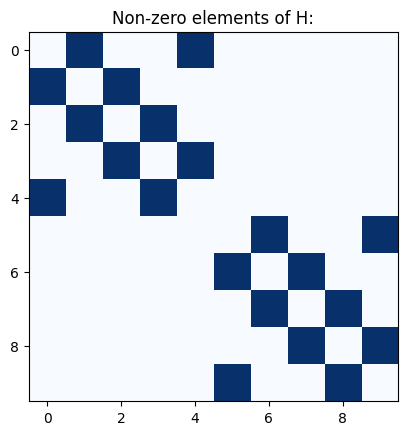

In [23]:
H = edf.hamiltonian(H)

print('Hamiltonian in operator form:')
print('H = ', H.opform)

print(f'\nHamiltonian in dense matrix form (type: {type(H.array)}):')
print(H.array.real)

print(f'\nHamiltonian in csr sparse matrix form (type: {type(H.sparse)}):')
print(H.sparse)

print('\nAn easy way to visualize an array is with pyplot.imshow and using array logic operators:')
from matplotlib import pyplot as plt
plt.imshow(H.array.real !=0, cmap = 'Blues' )
plt.title('Non-zero elements of H:')



#### The `.eigsolve()` method

Finally, once we've constructed our Hamiltonian object, we can solve for its eigenvalues and eigensolutions. To do this, we can use the built-in `.eigsolve()` method. This method uses either the dense numpy eigensolver or the scipy sparse eigensolver depending on the value of the argument `sparse`. If `sparse = True`, then `scipy.sparse.linalg.eigsh` is called, otherwise `numpy.linalg.eigh` is called. The `numeigs` and `which` arguments are passed to `.eigsh`. The eigenvalues and eigenvectors are stored in the attributes `.eigvals` and `.eigvecs`, respectively.

In [24]:
edf.hamiltonian.eigsolve?

Signature: edf.hamiltonian.eigsolve(self, sparse=True, numeigs=2, which='SA')
Docstring:
Calculate the eigenvalues and eigenvectors of the Hamiltonian.

Parameters
----------
sparse : bool
    Determine whether to calculate the eigensystem using sparse or dense linear algebra.
numeigs : int
    Number of eigenvalues and eigenvectors to return. Set to `'all'` to return all eigenvalues. 
which : str
    Determine the order in which to calculate the eigenvalues. See `scipy.sparse.linalg.eigsh`.
File:      c:\users\alexs\miniconda3\lib\site-packages\edinpy\fermion\fermion.py
Type:      function

In [25]:
H.eigsolve()

print('eigenvalues:', H.eigvals)
print('eigenvectors:')
print( H.eigvecs)

eigenvalues: [-3.9999998 -4.       ]
eigenvectors:
[[-0.25499994+0.26569548j  0.15574308-0.0391747j ]
 [-0.25500008+0.2656954j   0.15574305-0.03917472j]
 [-0.255     +0.2656954j   0.15574306-0.03917467j]
 [-0.25499985+0.26569545j  0.1557431 -0.03917465j]
 [-0.25499988+0.26569548j  0.15574309-0.03917469j]
 [ 0.22881684-0.10965338j  0.41656747-0.02609643j]
 [ 0.22881678-0.10965349j  0.41656747-0.02609643j]
 [ 0.22881675-0.10965344j  0.41656747-0.02609642j]
 [ 0.22881675-0.10965341j  0.41656747-0.02609638j]
 [ 0.22881678-0.10965338j  0.41656747-0.02609638j]]


## Example Code
### Electron gas in 1-D lattice of s-orbitals

Calculating matrix elements of Hamiltonian.
row: 100.00%, column: 100.00%
Ground state energy = -2.0
Ground state = [0.28151026-0.14405541j]


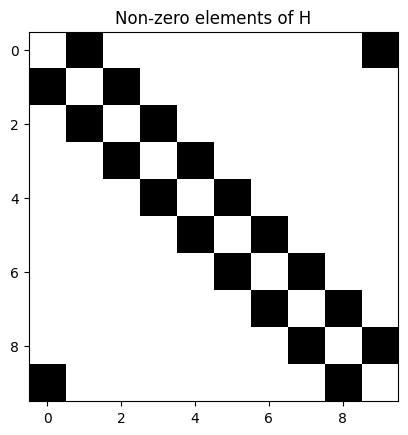

In [26]:
from matplotlib import pyplot as plt
from edinpy import fermion as edf

edf.clear()

Lx = 10
Nf = 1
x = edf.DoF(Lx, 'x')
mf = edf.model(Nf)

c = edf.operator

def ham(t):
    
    t = edf.scalar(t, 't')

    H = edf.null()

    for i in range(x.N-1):
        H += -t * (c(i).dag * c(i+1) + c(i+1).dag * c(i))

    H += -t * (c(0).dag * c(x.N-1) + c(x.N-1).dag * c(0))
    
    return H

H = edf.hamiltonian(ham(1))
plt.imshow(H.array.real != 0, cmap = 'binary')
plt.title('Non-zero elements of H')

H.eigsolve(numeigs = 1)
print(f'Ground state energy = {H.eigvals[0]}')
print(f'Ground state = {H.eigvecs[0]}')



### Fermi-Hubbard model at $\frac{1}{2}$ filling

Calculating matrix elements of Hamiltonian.
row: 100.00%, column: 100.00%
Ground state energy = -4.387778282165527
Ground state = [8.5885645e-09+3.414903e-08j]


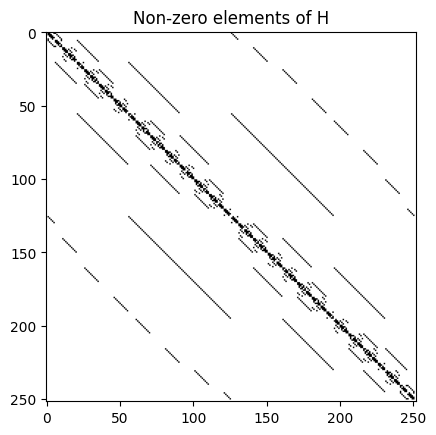

In [27]:
from matplotlib import pyplot as plt
from edinpy import fermion as edf

edf.clear()

Lx = 5
Nf = 5
x = edf.DoF(Lx, 'x')
spin = edf.DoF(2, 's')
mf = edf.model(Nf)

c = edf.operator
n = edf.number

def ham(t,U):
    
    t = edf.scalar(t, 't')
    U = edf.scalar(U, 'U')

    H = edf.null()

    for i in range(x.N):
        H += U * n((i,0)) * n((i,1))

    for s in range(spin.N):
        for i in range(x.N-1):
            H += -t * (c((i,s)).dag * c((i+1,s)) + c((i+1,s)).dag * c((i,s)))

    for s in range(spin.N):
        H += -t * (c((0,s)).dag * c((x.N-1,s)) + c((x.N-1,s)).dag * c((0,s)))
    
    return H

H = edf.hamiltonian(ham(1,2))
plt.imshow(H.array.real != 0, cmap = 'binary')
plt.title('Non-zero elements of H')

H.eigsolve(numeigs = 1)
print(f'Ground state energy = {H.eigvals[0]}')
print(f'Ground state = {H.eigvecs[0]}')

### Bose-Hubbard Model $\frac{1}{2}$ filling

Calculating matrix elements of Hamiltonian.
row: 100.00%, column: 100.00%
Ground state energy = -4.8221516609191895
Ground state = [-0.00013507+0.00010746j]


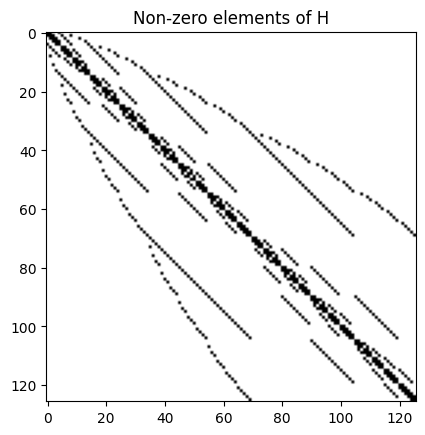

In [28]:
from matplotlib import pyplot as plt
from edinpy import boson as edb

edb.clear()

Lx = 5
Nb = 5
x = edb.DoF(Lx, 'x')
mf = edb.model(Nb)

b = edb.operator
n = edb.number

def ham(t,U):
    
    t = edb.scalar(t, 't')
    U = edb.scalar(U, 'U')

    H = edb.null()

    for i in range(x.N):
        H += U * n(i) * (n(i) - 1)

    for i in range(x.N-1):
        H += -t * (b(i).dag * b(i+1) + b(i+1).dag * b(i))

    H += -t * (b(0).dag * b(x.N-1) + b(x.N-1).dag * b(0))
    
    return H

H = edb.hamiltonian(ham(1,2))
plt.imshow(H.array.real != 0, cmap = 'binary')
plt.title('Non-zero elements of H')

H.eigsolve(numeigs = 1)
print(f'Ground state energy = {H.eigvals[0]}')
print(f'Ground state = {H.eigvecs[0]}')